In [1]:
from __future__ import division
from collections import Counter, OrderedDict
from gensim.models import KeyedVectors, FastText
from IPython.display import display, HTML
from pprint import pprint
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, classification_report, precision_recall_fscore_support, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.svm import LinearSVC
import copy
import itertools
import joblib
import math
import numpy as np
import operator
import pandas as pd
import pickle
import scipy
import time

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
cuisine2id = {'NorthAmerican': 0,
               'WesternEuropean': 1,
               'NorthernEuropean': 2,
               'EasternEuropean': 3,
               'EastAsian': 4,
               'SoutheastAsian': 5,
               'SouthAsian': 6,
               'African': 7,
               'LatinAmerican': 8,
               'MiddleEastern': 9,
               'SouthernEuropean': 10}
id2cuisine = {v: k for k, v in cuisine2id.items()}

cuisine2id_merged = {'Western': 0, 'Eastern': 1, 'SouthAsian': 2, 'Southern': 3}
id2cuisine_merged = {v: k for k, v in cuisine2id_merged.items()}

def mk_joint_vocab_ing_list2cuisine(model, ing_list2cuisine):
    joint_vocab_ing_list2cuisine = []
    for ing_list_tuple in ing_list2cuisine:
        ing_list_to_append = []
        for ing in ing_list_tuple[0]:
            if ing in model:
                ing_list_to_append.append(ing)
        if ing_list_to_append:
            ing_list2cuisine_tuple_to_append = (ing_list_to_append, ing_list_tuple[1])
            joint_vocab_ing_list2cuisine.append(ing_list2cuisine_tuple_to_append)

    print('Number of ing_lists usable with this model: ', len(joint_vocab_ing_list2cuisine))
    return joint_vocab_ing_list2cuisine

def mk_cuisine_labels(ing_list2cuisine):
    cuisine_labels = list(set([ing_list_tuple[1] for ing_list_tuple in ing_list2cuisine]))
    cuisine_labels.sort()
    print('Number of cuisines: ', len(cuisine_labels))

    cuisine_counts = [cuisine_labels.index(ing_list_tuple[1]) for ing_list_tuple in ing_list2cuisine]
    for i, cuisine in enumerate(cuisine_labels):
        print(cuisine_counts.count(i), ' ', cuisine_labels[i], ' ing_lists')
    return cuisine_labels



def mk_Y(joint_vocab_ing_list2cuisine):
    return np.array([cuisine2id[ing_list_tuple[1]] for ing_list_tuple in joint_vocab_ing_list2cuisine])
# .decode('utf-8')

def mk_Y_merged(joint_vocab_ing_list2cuisine):
#    return np.array([cuisine2id_merged[ing_list_tuple[1]] for ing_list_tuple in joint_vocab_ing_list2cuisine])
    return np.array([cuisine2id_merged[ing_list_tuple[1].decode('utf-8')] for ing_list_tuple in joint_vocab_ing_list2cuisine])


# creating representations
# 0.  Representation
def mk_ing_list2simple_avged_model_vec(model, joint_vocab_ing_list2cuisine):
    joint_vocab_ing_lists = [ing_list_tuple[0] for ing_list_tuple in joint_vocab_ing_list2cuisine]
    ing_list2simple_avged_model_vec = [np.sum([model[ing] for ing in ing_list], axis=0)
                                       for ing_list in joint_vocab_ing_lists]
    return np.array(ing_list2simple_avged_model_vec)


# 3. Representation
def mk_ing_list2tfidf_vec_fitting_tfidf_vectorizer(joint_vocab_ing_list2cuisine_cvtrain,
                                                   joint_vocab_ing_list2cuisine_test):
    ing_list2cuisine = np.append(joint_vocab_ing_list2cuisine_cvtrain, joint_vocab_ing_list2cuisine_test, axis=0)
    tfidf_vectorizer = TfidfVectorizer(preprocessor=lambda x: x,
                                       tokenizer=lambda x: x,
                                       norm='l1',
                                       use_idf=True)  # already preprc+tknzd
    tfidf_vectorizer.fit_transform([ing_list[0] for ing_list in ing_list2cuisine])
    ing_list2tfidf_vec_cvtrain = tfidf_vectorizer.transform(
        [ing_list[0] for ing_list in joint_vocab_ing_list2cuisine_cvtrain])
    ing_list2tfidf_vec_test = tfidf_vectorizer.transform(
        [ing_list[0] for ing_list in joint_vocab_ing_list2cuisine_test])
    return ing_list2tfidf_vec_cvtrain, ing_list2tfidf_vec_test, tfidf_vectorizer


def mk_ing_list_representations_and_shape_dict(model,
                                               joint_vocab_ing_list2cuisine_cvtrain,
                                               joint_vocab_ing_list2cuisine_test):

    # 3 cvtrain+test
    ing_list2tfidf_vec_cvtrain, ing_list2tfidf_vec_test, tfidf_vectorizer = \
        mk_ing_list2tfidf_vec_fitting_tfidf_vectorizer(joint_vocab_ing_list2cuisine_cvtrain,
                                                       joint_vocab_ing_list2cuisine_test)

    # 0
    ing_list2simple_avged_model_vec_cvtrain = mk_ing_list2simple_avged_model_vec(
        model, joint_vocab_ing_list2cuisine_cvtrain)
    ing_list2simple_avged_model_vec_test = mk_ing_list2simple_avged_model_vec(
        model, joint_vocab_ing_list2cuisine_test)

    # 1
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    ing_list2tfidf_avged_model_vec_cvtrain = ing_list2tfidf_vec_cvtrain.dot(
        np.array([model[ing] for ing in tfidf_feature_names]))
    ing_list2tfidf_avged_model_vec_test = ing_list2tfidf_vec_test.dot(
        np.array([model[ing] for ing in tfidf_feature_names]))

    # 2
    ing_list2tfidf_avged_model_vec_concat_2tfidf_vec_cvtrain = np.concatenate(
        [ing_list2tfidf_vec_cvtrain.toarray(), ing_list2tfidf_avged_model_vec_cvtrain], axis=1)
    ing_list2tfidf_avged_model_vec_concat_2tfidf_vec_test = np.concatenate(
        [ing_list2tfidf_vec_test.toarray(), ing_list2tfidf_avged_model_vec_test], axis=1)

    representations_dict = {
        #'0_ing_lists2simple_avged_model_vec': [ing_list2simple_avged_model_vec_cvtrain, ing_list2simple_avged_model_vec_test],
        #'1_ing_list2tfidf_avged_model_vec': [ing_list2tfidf_avged_model_vec_cvtrain, ing_list2tfidf_avged_model_vec_test],
        '2_ing_list2tfidf_avged_model_vec_concat_2tfidfvec_': [ing_list2tfidf_avged_model_vec_concat_2tfidf_vec_cvtrain, ing_list2tfidf_avged_model_vec_concat_2tfidf_vec_test],
        # '3ing_list2tfidf_vec': [ing_list2tfidf_vec_cvtrain, ing_list2tfidf_vec_test]
    }
    shape_dict = {
        #'0_ing_lists2simple_avged_model_vec_shape': [ing_list2simple_avged_model_vec_cvtrain.shape, ing_list2simple_avged_model_vec_test.shape],
        #'1_ing_list2tfidf_avged_model_vec': [ing_list2tfidf_avged_model_vec_cvtrain.shape, ing_list2tfidf_avged_model_vec_test.shape],
        '2_ing_list2tfidf_avged_model_vec_concat_2tfidfvec': [ing_list2tfidf_avged_model_vec_concat_2tfidf_vec_cvtrain.shape, ing_list2tfidf_avged_model_vec_concat_2tfidf_vec_test.shape],
        # '3_ing_list2tfidf_vec': [ing_list2tfidf_vec_cvtrain.shape, ing_list2tfidf_vec_test.shape]
    }
    return representations_dict, shape_dict


logregstring = 'logreg'
svcstring = 'svc'
cuisine_prediction_name = 'cuisine_prediction_' + svcstring + '__'
cuisine_prediction_name = 'cuisine_prediction_' + logregstring + '__'

def predict_y_cvtrain_and_y_test(model_dict, ing_list2cuisine_cvtrain_, ing_list2cuisine_test_):
    for model_name, model in model_dict.items():
        joint_vocab_ing_list2cuisine_cvtrain = mk_joint_vocab_ing_list2cuisine(model, ing_list2cuisine_cvtrain_)
        joint_vocab_ing_list2cuisine_test = mk_joint_vocab_ing_list2cuisine(model, ing_list2cuisine_test_)
        representations_dict, shape_dict = mk_ing_list_representations_and_shape_dict(
            model,
            joint_vocab_ing_list2cuisine_cvtrain,
            joint_vocab_ing_list2cuisine_test)

        Y_cvtrain = mk_cuisine_labels(joint_vocab_ing_list2cuisine_cvtrain)
        Y_test = mk_cuisine_labels(joint_vocab_ing_list2cuisine_test)
        for representation_name, cvtrain_and_test_representation in representations_dict.items():
            file_name_base = base_path + cuisine_prediction_name + model_name + '_' + representation_name + '_'
            gridsearch_clf = joblib.load(file_name_base + 'gridsearch_clf.joblib.pkl')
            best_estimator = gridsearch_clf.best_estimator_
            Y_cvtrain_predicted = cross_val_predict(best_estimator, cvtrain_and_test_representation[0], 
                                                    Y_cvtrain, cv=10, 
                                                    n_jobs=-1
                                                    #n_jobs=-1
                                                   )
            Y_test_predicted = best_estimator.predict(cvtrain_and_test_representation[1])
    return Y_cvtrain, Y_test, Y_cvtrain_predicted, Y_test_predicted

### wiki_fastext embedding takes around 5 minutes to load

In [4]:
data_path = '../data/'
path_to_model_googlenews = data_path + 'GoogleNews-vectors-negative300.bin'
path_to_model_wiki_fasttext_vec = data_path + 'wiki.en/wiki.en.vec'
path_to_model_wiki_fasttext_bin = data_path + 'wiki.en/wiki.en.bin'
path_to_model_im2rec_base = data_path + 'recipe1M/vocab.bin'
path_to_model_im2rec_fasttext = data_path + 'w2v_fasttext_im2r_300.bin'
path_to_model_im2rec_joint_null = data_path + 'ingredient_embeds.csv'
path_to_model_im2rec_joint_avg = data_path + 'ingredient_embeds_w_avg_instr_vec.csv'
path_to_ahn_recipes_with_cuisines = data_path + 'ahn_flavour_network/srep00196-s3.csv'
path_to_ahn_merged_ing_list2cuisine_cvtrain = 'merged_ing_list2cuisine_cvtrain.pkl.npy'
path_to_ahn_merged_ing_list2cuisine_test = 'merged_ing_list2cuisine_test.pkl.npy'
path_to_ahn_ing_list2cuisine_cvtrain = 'cvtrain_and_test_data/ing_list2cuisine_cvtrain.pkl.npy'
path_to_ahn_ing_list2cuisine_test = 'cvtrain_and_test_data/ing_list2cuisine_test.pkl.npy'

#model = 'model_im2rec_joint_null' # logreg
model = 'model_wiki_fasttext' # SVC
if model == 'model_googlenews':
    models = {
        'model_googlenews': KeyedVectors.load_word2vec_format(path_to_model_googlenews, binary=True),
    }

if model == 'model_wiki_fasttext':
    models = {
        'model_wiki_fasttext': FastText.load_fasttext_format(path_to_model_wiki_fasttext_bin).wv,
    }

if model == 'model_im2rec_joint_null':
    models = {
        'model_im2rec_joint_null': KeyedVectors.load_word2vec_format(path_to_model_im2rec_joint_null, binary=False),
    }

if model == 'model_im2rec_joint_avg':
    models = {
        'model_im2rec_joint_avg': KeyedVectors.load_word2vec_format(path_to_model_im2rec_joint_avg, binary=False),
    }

if model == 'model_im2rec_base':
    models = {
        'model_im2rec_base': KeyedVectors.load_word2vec_format(path_to_model_im2rec_base, binary=True),
    }

if model == 'model_im2rec_fasttext':
    models = {
        'model_im2rec_fasttext': FastText.load_fasttext_format(path_to_model_im2rec_fasttext).wv
    }
    
representations = [
    '0_ing_lists2simple_avged_model_vec',
    '1_ing_list2tfidf_avged_model_vec',
    '2_ing_list2tfidf_avged_model_vec_concat_2tfidfvec'
    #'3_ing_list2tfidf_vec'
]

representation = representations[0]  # best logreg
representation = representations[2]  # best SVC


In [5]:
with open(path_to_ahn_recipes_with_cuisines, 'r') as f:
    ing_list2cuisine = np.asarray([(l.strip().split(',')[1::], l.split(',')[0]) for l in f.readlines()[4::]])

In [6]:
ing_list2cuisine_merged_cvtrain = np.load(path_to_ahn_merged_ing_list2cuisine_cvtrain)
ing_list2cuisine_merged_test = np.load(path_to_ahn_merged_ing_list2cuisine_test)

cuisinelabels = mk_cuisine_labels(np.concatenate(
        [ing_list2cuisine_merged_cvtrain, ing_list2cuisine_merged_test], axis=0))


Number of cuisines:  4
2969   b'Eastern'  ing_lists
621   b'SouthAsian'  ing_lists
8094   b'Southern'  ing_lists
44814   b'Western'  ing_lists


In [7]:
#ing_list2cuisine_cvtrain = np.load(path_to_ahn_ing_list2cuisine_cvtrain)
#ing_list2cuisine_test = np.load(path_to_ahn_ing_list2cuisine_test)

ing_list2cuisine_merged_cvtrain = np.load(path_to_ahn_merged_ing_list2cuisine_cvtrain)
ing_list2cuisine_merged_test = np.load(path_to_ahn_merged_ing_list2cuisine_test)

base_path = './resultsLinearSVC/'  # final linear SVC
#base_path = './resultsLogReg/'  # final log Reg
filename_addition = 'SVC'
#filename_addition = 'logReg'

base_path2 = './training_scripts/'
varlist_path = base_path + 'cuisine_prediction_logreg__'+ model + '_' + representation +'__list_of_vars.joblib.pkl'

### better to load via joblib; training took 10 minutes last time with cvpredict-n_jobs=-1

In [11]:
#Y_cvtrain, Y_test, Y_cvtrain_predicted, Y_test_predicted = predict_y_cvtrain_and_y_test(
    #models, ing_list2cuisine_cvtrain, ing_list2cuisine_test)

X_cvtrain, X_test, Y_cvtrain, Y_test, Y_cvtrain_predicted, Y_test_predicted = joblib.load(varlist_path)

In [13]:
cuisine_label_indices_cvtrain = mk_Y_merged(ing_list2cuisine_merged_cvtrain)
cuisine_labels_cvtrain = [id2cuisine_merged[cuisine_index] for cuisine_index in cuisine_label_indices_cvtrain]
cuisine_label_indices_test = mk_Y_merged(ing_list2cuisine_merged_test)
cuisine_labels_test = [id2cuisine_merged[cuisine_index] for cuisine_index in cuisine_label_indices_test]

Y_cvtrain_labels = [cuisine_labels_cvtrain[x] for x in Y_cvtrain]
Y_cvtrain_predicted_labels = [cuisine_labels_cvtrain[x] for x in Y_cvtrain_predicted]
Y_test_labels = [cuisine_labels_test[x] for x in Y_test]
Y_test_predicted_labels = [cuisine_labels_test[x] for x in Y_test_predicted]

In [ ]:
from pandas_ml import ConfusionMatrix
from sklearn.metrics import confusion_matrix

mat_cvtrain = confusion_matrix(Y_cvtrain, Y_cvtrain_predicted)
mat_test = confusion_matrix(Y_test, Y_test_predicted)

mat_cvtrain_norm = mat_cvtrain.astype('float') / mat_cvtrain.sum(axis=1)[:, np.newaxis]
mat_test_norm = mat_test.astype('float') / mat_test.sum(axis=1)[:, np.newaxis]

mat_cvtrain_norm
mat_test_norm

In [ ]:
cuisines_merged = [cuisine for cuisine in cuisine2id_merged.keys()]
cuisines_merged.sort()
cuisines_merged

## Confusion Matrices

Text(0.5, 6.799999999999997, 'Actual Merged Cuisine Region')

Text(6.800000000000004, 0.5, 'Predicted Merged Cuisine Region')

[Text(0, 0.5, 'Eastern'),
 Text(0, 1.5, 'SouthAsian'),
 Text(0, 2.5, 'Southern'),
 Text(0, 3.5, 'Western')]

/media/zeug/CODE/im2recipe-Pytorch/env3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


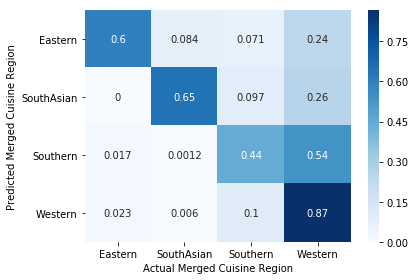

In [28]:
#%matplotlib qt
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sn


mat_cvtrain_norm_df = pd.DataFrame(mat_cvtrain_norm, 
                     index=[s for s in cuisines_merged], 
                     columns=[s for s in cuisines_merged])

mat_test_norm_df = pd.DataFrame(mat_test_norm, 
                     index=[s for s in cuisines_merged], 
                     columns=[s for s in cuisines_merged])

#svm_cvtrain = sn.heatmap(mat_cvtrain_norm_df, annot=True, cmap="Blues")
svm_test = sn.heatmap(mat_test_norm_df, annot=True, cmap="Blues")
plt.xlabel('Actual Merged Cuisine Region')
plt.ylabel('Predicted Merged Cuisine Region')
#svm_cvtrain.set_yticklabels(svm_cvtrain.get_yticklabels(), rotation=0)
svm_test.set_yticklabels(svm_test.get_yticklabels(), rotation=0)
#plt.savefig('cuisine_confusion_mat_cvtrain' + filename_addition + '.png', dpi=72)
plt.savefig('cuisine_confusion_mat_test' + filename_addition + '.png', dpi=72)

# t-SNE

## TFIDF Ingredient Weight calculation

### tfidf-inglists
- for inglist2cuisine
- for merged inglist2cuisine

In [6]:
def mk_ing_list2tfidf_vec_fitting_tfidf_vectorizer(joint_vocab_ing_list2cuisine_cvtrain,
                                                   joint_vocab_ing_list2cuisine_test):
    ing_list2cuisine = np.append(joint_vocab_ing_list2cuisine_cvtrain, joint_vocab_ing_list2cuisine_test, axis=0)
    tfidf_vectorizer = TfidfVectorizer(preprocessor=lambda x: x,
                                       tokenizer=lambda x: x,
                                       norm='l1',
                                       use_idf=True)  # already preprc+tknzd
    ing_lists2tfidf_vec = tfidf_vectorizer.fit_transform([ing_list[0] for ing_list in ing_list2cuisine])
    return ing_lists2tfidf_vec, tfidf_vectorizer

ing_lists2tfidf_vec_merged, tfidf_vectorizer_merged = mk_ing_list2tfidf_vec_fitting_tfidf_vectorizer(ing_list2cuisine_merged_cvtrain, ing_list2cuisine_merged_test)
ing_lists2tfidf_vec, tfidf_vectorizer = mk_ing_list2tfidf_vec_fitting_tfidf_vectorizer(ing_list2cuisine_cvtrain, ing_list2cuisine_test)

In [7]:
ing_lists2tfidf_vec_merged[4312]

<1x381 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

### Some stats about the ingredients within the inglists

In [ ]:
ing2tfidf = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))
most_common_ings = sorted(ing2tfidf.items(), key=lambda x: x[1])
least_common_ings = sorted(ing2tfidf.items(), key=lambda x: x[1], reverse=True)

print('The most common ingredients in the ing_lists2cuisines are: ')
pprint(most_common_ings[:10])
print('')
print('The least common ingredients in the ing_lists2cuisines are: ')
pprint(least_common_ings[:10])

### t-SNE of the TF-IDF inglist embeddings

In [16]:
ing_list2cuisine_cvtrain = np.load(path_to_ahn_ing_list2cuisine_cvtrain)
ing_list2cuisine_test = np.load(path_to_ahn_ing_list2cuisine_test)

ing_list2cuisine_merged_cvtrain = np.load(path_to_ahn_merged_ing_list2cuisine_cvtrain)
ing_list2cuisine_merged_test = np.load(path_to_ahn_merged_ing_list2cuisine_test)

ing_list2cuisine_cvtrain = [[inglisttuple[0], inglisttuple[1].decode('UTF-8')] for inglisttuple in ing_list2cuisine_cvtrain]
ing_list2cuisine_test = [[inglisttuple[0], inglisttuple[1].decode('UTF-8')] for inglisttuple in ing_list2cuisine_test]

In [17]:
ing_list2cuisine_cvtrain[0]
ing_list2cuisine_merged_cvtrain[0]
ing_list2cuisine_cvtrain[8090]
ing_list2cuisine_merged_cvtrain[8090]
ing_list2cuisine_cvtrain[5000]
ing_list2cuisine_merged_cvtrain[5000]

[['chicken', 'cinnamon', 'soy_sauce', 'onion', 'ginger'], 'African']

array([list(['chicken', 'cinnamon', 'soy_sauce', 'onion', 'ginger']),
       b'Southern'], dtype=object)

[['butter',
  'cheese',
  'lemon_juice',
  'wheat',
  'yeast',
  'lemon_peel',
  'vanilla',
  'ginger',
  'cocoa',
  'buttermilk',
  'gelatin',
  'cranberry',
  'egg',
  'milk',
  'cream'],
 'NorthAmerican']

array([list(['turkey', 'butter', 'wheat', 'thyme', 'onion', 'black_pepper']),
       b'Western'], dtype=object)

[['wheat', 'nutmeg', 'cinnamon', 'vegetable_oil'], 'LatinAmerican']

array([list(['tomato', 'cilantro', 'onion', 'black_pepper', 'tabasco_pepper', 'shrimp', 'cucumber', 'lime']),
       b'Southern'], dtype=object)

In [18]:
cuisines = cuisine2id.keys()
cuisine_label_indices = mk_Y(np.append(ing_list2cuisine_cvtrain, ing_list2cuisine_test, axis=0))
cuisine_labels = [id2cuisine[cuisine_index] for cuisine_index in cuisine_label_indices]

cuisines_merged = cuisine2id_merged.keys()
cuisine_label_indices_merged = mk_Y_merged(np.append(ing_list2cuisine_merged_cvtrain, ing_list2cuisine_merged_test, axis=0))
cuisine_labels_merged = [id2cuisine_merged[cuisine_index] for cuisine_index in cuisine_label_indices_merged]


#cuisines
cuisines_merged
#cuisine_label_indices[1]
cuisine_label_indices_merged[1]

#cuisine_counts = [cuisine2id[ing_list_tuple[1].decode('utf-8')] for ing_list_tuple in ing_list2cuisine_cvtrain]
#for k, v in id2cuisine.items():
#    print(cuisine_counts.count(k), ' ', v, ' ing_lists')


dict_keys(['Western', 'Eastern', 'SouthAsian', 'Southern'])

3

In [11]:
from MulticoreTSNE import MulticoreTSNE
from sklearn.manifold import TSNE
import scipy

tsne = MulticoreTSNE(n_components=2, perplexity=50, random_state=0, n_iter=1000, n_jobs=16)
#tsne = TSNE(n_components=2, random_state=0)

In [12]:
ing_list2wikiftconcat = np.append(X_cvtrain, X_test, axis=0)

## takes around 10 minutes for n_iter=1000, n_jobs=16

In [13]:
#ing_lists2tfidf_vec_2d = tsne.fit_transform(ing_lists2tfidf_vec.todense())
ing_list2wikiftconcat_2d= tsne.fit_transform(ing_list2wikiftconcat)

In [14]:
#joblib.dump(ing_lists2tfidf_vec_2d, 'ing_lists2tfidf_vec_2d_perp30.joblib.pkl')
#joblib.dump(ing_lists2tfidf_vec_2d, 'ing_lists2tfidf_vec_2d_perp50.joblib.pkl')
#joblib.dump(ing_lists2tfidf_vec_2d, 'ing_lists2tfidf_vec_2d_perp5.joblib.pkl')
#joblib.dump(ing_list2wikiftconcat_2d, 'ing_list2wikiftconcat_2d_perp50a.joblib.pkl')

['ing_list2wikiftconcat_2d_perp50a.joblib.pkl']

     x_t-SNE    y_t-SNE  cuisine
0  14.562106 -12.089505  African
1   8.333318  -4.838620  African
     x_t-SNE    y_t-SNE   cuisine
0  14.562106 -12.089505  Southern
1   8.333318  -4.838620  Southern


,x_t-SNE,y_t-SNE,cuisine,cuisine_color,cuisine_marker
0,14.562106,-12.089505,African,#8b4500,*
1,8.333318,-4.838620,African,#8b4500,*


,x_t-SNE,y_t-SNE,cuisine,cuisine_color,cuisine_marker
0,14.562106,-12.089505,Southern,black,.
1,8.333318,-4.838620,Southern,black,.


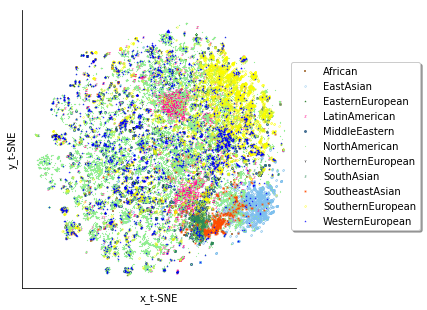

In [22]:
#%matplotlib qt
%matplotlib inline

ing_lists2tfidf_vec_2d = joblib.load('ing_lists2tfidf_vec_2d_perp50.joblib.pkl')
#ing_lists2tfidf_vec_2d_merged = joblib.load('ing_lists2tfidf_vec_2d_merged_perp50.joblib.pkl')

ing_lists2tfidf_vec_2d_df = pd.DataFrame(ing_lists2tfidf_vec_2d).rename(index=str, columns={0: "x_t-SNE", 1: "y_t-SNE"})
ing_lists2tfidf_vec_2d_df_merged = pd.DataFrame(ing_lists2tfidf_vec_2d).rename(index=str, columns={0: "x_t-SNE", 1: "y_t-SNE"})
#ing_lists2tfidf_vec_2d_df_merged = pd.DataFrame(ing_lists2tfidf_vec_2d_merged).rename(index=str, columns={0: "x_t-SNE", 1: "y_t-SNE"})


cuisine_labels_df = pd.DataFrame(cuisine_labels).rename(index=str, columns={0: "cuisine"})
cuisine_labels_df_merged = pd.DataFrame(cuisine_labels_merged).rename(index=str, columns={0: "cuisine"})

data_df = pd.concat([ing_lists2tfidf_vec_2d_df, cuisine_labels_df], axis=1)
data_df_merged = pd.concat([ing_lists2tfidf_vec_2d_df_merged, cuisine_labels_df_merged], axis=1)

print(data_df[:2])
print(data_df_merged[:2])


palette_merged = OrderedDict([
    ('Eastern', '#7ec0ee'), ## 'skyblue2'
    ('SouthAsian', '#ff4c00'),  ###'darkorange'
    ('Southern', 'black'),
    ('Western', '#90EE90')  ## 'palegreen2'
])

markers_odict_merged = OrderedDict([
    ('Eastern', '*'),  
    ('SouthAsian', '$o$'),  
    ('Southern', '.'),
    ('Western', '$O$')
])


palette = OrderedDict([
    ('NorthernEuropean', 'black'),
    ('EasternEuropean', 'darkgreen'),
    ('NorthAmerican', '#90EE90'),  ## 'palegreen2'
    ('WesternEuropean', 'blue'),  ### 'dodgerblue2'
    #
    ('EastAsian', '#7ec0ee'), ## 'skyblue2'
    ('SoutheastAsian', '#ff4c00'),  ###'darkorange'
    #
    ('SouthAsian', "seagreen"), 
    #
    ('LatinAmerican', '#FF1493'),  ### 'deeppink1'
    ('SouthernEuropean', '#ffff00'),  ### 'yellow4'
    ('MiddleEastern', '#36648b'),  # steelblue4
    ('African', '#8b4500')  ###'darkorange4'
])

markers_odict = OrderedDict([
    ('NorthernEuropean', '|'),
    ('EasternEuropean', '$o$'),
    ('NorthAmerican', '*'),
    ('WesternEuropean', '$z$'),
    ('EastAsian', 'x'),  ###
    ('SoutheastAsian', '.'),
    ('SouthAsian', '$Y$'),  ###
    ('LatinAmerican', '$s$'),
    ('SouthernEuropean', 'X'),
    ('MiddleEastern', '$o$'),
    ('African', '*'),   ###
])

markers = [marker for marker in markers_odict.values()]
markers_merged = [marker for marker in markers_odict_merged.values()]

cuisine_colors = pd.DataFrame([palette[cuisine] for cuisine in cuisine_labels]).rename(index=str, columns={0: "cuisine_color"})
cuisine_colors_merged = pd.DataFrame([palette_merged[cuisine] for cuisine in cuisine_labels_merged]).rename(index=str, columns={0: "cuisine_color"})

cuisine_markers = pd.DataFrame([markers_odict[cuisine] for cuisine in cuisine_labels]).rename(index=str, columns={0: "cuisine_marker"})
cuisine_markers_merged = pd.DataFrame([markers_odict_merged[cuisine] for cuisine in cuisine_labels_merged]).rename(index=str, columns={0: "cuisine_marker"})
data_df = pd.concat([data_df, cuisine_colors, cuisine_markers], axis=1)
data_df_merged = pd.concat([data_df_merged, cuisine_colors_merged, cuisine_markers_merged], axis=1)
data_df[:2]
data_df_merged[:2]

import pylab
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
rcParams.update({'pgf.rcfonts': True})  # False if want to use latex documents fonts
rcParams['figure.autolayout'] = False


g = sns.lmplot(x='x_t-SNE',  # Horizontal axis
               y='y_t-SNE',  # Vertical axis
               data=data_df,  # Data source
               fit_reg=False,  # Don't fix a regression line
               legend=False,  # legend to be drawn separately later
               #legend_out=True,
               height=12,
               hue='cuisine',  # color according to column in data_df
               palette=palette,
               #markers='.'
               markers=markers,
               # aspect=2  # size and dimension
               scatter_kws={'s':4, 'alpha':0.9, 'linewidths':0.1}#,'edgecolor':'k'}
               )
ax = g.axes

#fig.suptitle('300-Dimensional im2recipe-fasttext-embedding of categorized ingredients as 2-D t-SNE', weight='bold').set_fontsize('14')
lgd = g.fig.get_axes()[0].legend(loc='right', 
           bbox_to_anchor=(1.47, 0.51),
           ncol=1, 
           fancybox=True, 
           shadow=True)

g.set(xticks=[])
g.set(yticks=[])
fig = g.fig

fig_width_cm = 21                         # A4 page
fig_height_cm = 29.7
inches_per_cm = 1 / 2.54              # Convert cm to inches
fig_width = fig_width_cm * inches_per_cm # width in inches
fig_height = fig_height_cm * inches_per_cm       # height in inches
fig.set_size_inches(fig_width/2, fig_width/2)

# save to file
fig.savefig('tsne-cuisine-tfidf-perp50-unmerged_unmergedtsne.pdf', dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))
fig.savefig('tsne-cuisine-tfidf-perp50-unmerged_unmergedtsne.pgf', dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))

     x_t-SNE   y_t-SNE   cuisine
0 -20.929732 -5.778952  Southern
1 -10.266675 -4.453991  Southern


,x_t-SNE,y_t-SNE,cuisine,cuisine_color,cuisine_marker
0,-20.929732,-5.778952,Southern,black,.
1,-10.266675,-4.453991,Southern,black,.


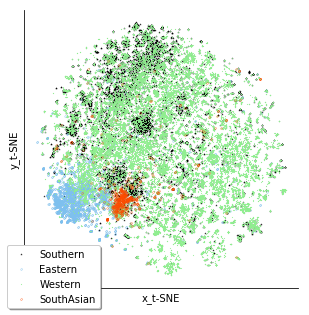

In [18]:
#%matplotlib qt
%matplotlib inline

#ing_list2wikiftconcat_2d = joblib.load('ing_list2wikiftconcat_2d_perp50a.joblib.pkl')
ing_list2wikiftconcat_2d_df = joblib.load('ing_lists2tfidf_vec_2d_merged_perp50.joblib.pkl')


ing_list2wikiftconcat_2d_df = pd.DataFrame(ing_list2wikiftconcat_2d).rename(index=str, columns={0: "x_t-SNE", 1: "y_t-SNE"})

cuisine_labels_df_merged = pd.DataFrame(cuisine_labels_merged).rename(index=str, columns={0: "cuisine"})
data_df_merged = pd.concat([ing_list2wikiftconcat_2d_df, cuisine_labels_df_merged], axis=1)

print(data_df_merged[:2])

palette_merged = OrderedDict([
    ('Eastern', '#7ec0ee'), ## 'skyblue2'
    ('SouthAsian', '#ff4c00'),  ###'darkorange'
    ('Southern', 'black'),
    ('Western', '#90EE90')  ## 'palegreen2'
])

markers_odict_merged = OrderedDict([
    ('Eastern', '*'),  
    ('SouthAsian', '$o$'),  
    ('Southern', '.'),
    ('Western', '$O$')
])

markers_merged = [marker for marker in markers_odict_merged.values()]

cuisine_colors_merged = pd.DataFrame([palette_merged[cuisine] for cuisine in cuisine_labels_merged]).rename(index=str, columns={0: "cuisine_color"})
cuisine_markers_merged = pd.DataFrame([markers_odict_merged[cuisine] for cuisine in cuisine_labels_merged]).rename(index=str, columns={0: "cuisine_marker"})
data_df_merged = pd.concat([data_df_merged, cuisine_colors_merged, cuisine_markers_merged], axis=1)
data_df_merged[:2]

import seaborn as sns
from matplotlib import rcParams
rcParams.update({'pgf.rcfonts': True})  # False if want to use latex documents fonts
rcParams['figure.autolayout'] = False

g = sns.lmplot(x='x_t-SNE',  # Horizontal axis
               y='y_t-SNE',  # Vertical axis
               data=data_df_merged,  # Data source
               fit_reg=False,  # Don't fix a regression line
               legend=False,  # legend to be drawn separately later
               #legend_out=True,
               height=12,
               hue='cuisine',  # color according to column in data_df
               palette=palette_merged,
               #markers='.'
               markers=markers_merged,
               # aspect=2  # size and dimension
               scatter_kws={'s':4, 'alpha':0.9, 'linewidths':0.1}#,'edgecolor':'k'}
              )
ax = g.axes

lgd = g.fig.get_axes()[0].legend(loc='lower left', 
           bbox_to_anchor=(-0.08, -0.09),
           ncol=1, 
           fancybox=True, 
           shadow=True)

g.set(xticks=[])
g.set(yticks=[])
fig = g.fig

#fig_width_cm = 21                         # A4 page
#fig_height_cm = 29.7
fig_width_cm = 21                         # A4 page
fig_height_cm = 29.7
inches_per_cm = 1 / 2.54              # Convert cm to inches
fig_width = fig_width_cm * inches_per_cm # width in inches
fig_height = fig_height_cm * inches_per_cm       # height in inches
fig.set_size_inches(fig_width/2, fig_width/2)

fig.savefig('tsne-cuisine-tfidf-perp50-merged_mergedtsne.pdf', dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))
fig.savefig('tsne-cuisine-tfidf-perp50-merged_mergedtsne.pgf', dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))

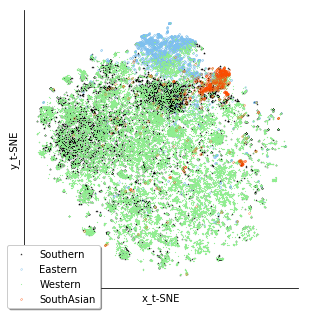

In [166]:
#%matplotlib qt
%matplotlib inline

g = sns.lmplot(x='x_t-SNE',  # Horizontal axis
               y='y_t-SNE',  # Vertical axis
               data=data_df_merged,  # Data source
               fit_reg=False,  # Don't fix a regression line
               legend=False,  # legend to be drawn separately later
               #legend_out=True,
               height=12,
               hue='cuisine',  # color according to column in data_df
               palette=palette_merged,
               #markers='.'
               markers=markers_merged,
               # aspect=2  # size and dimension
               scatter_kws={'s':4, 'alpha':0.9, 'linewidths':0.1}#,'edgecolor':'k'}
               )
ax = g.axes

lgd = g.fig.get_axes()[0].legend(loc='lower left', 
           bbox_to_anchor=(-0.08, -0.09),
           ncol=1, 
           fancybox=True, 
           shadow=True)

g.set(xticks=[])
g.set(yticks=[])
fig = g.fig

#fig_width_cm = 21                         # A4 page
#fig_height_cm = 29.7
fig_width_cm = 21                         # A4 page
fig_height_cm = 29.7
inches_per_cm = 1 / 2.54              # Convert cm to inches
fig_width = fig_width_cm * inches_per_cm # width in inches
fig_height = fig_height_cm * inches_per_cm       # height in inches
fig.set_size_inches(fig_width/2, fig_width/2)

# save to file
fig.savefig('tsne-cuisine-wiki-perp50-unmerged_mergedtsne.pdf', dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))
fig.savefig('tsne-cuisine-wiki-perp50-unmerged_mergedtsne.pgf', dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))

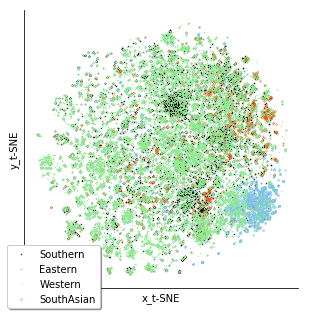

In [168]:
#%matplotlib qt
%matplotlib inline

g = sns.lmplot(x='x_t-SNE',  # Horizontal axis
               y='y_t-SNE',  # Vertical axis
               data=data_df_merged,  # Data source
               fit_reg=False,  # Don't fix a regression line
               legend=False,  # legend to be drawn separately later
               #legend_out=True,
               height=12,
               hue='cuisine',  # color according to column in data_df
               palette=palette_merged,
               #markers='.'
               markers=markers_merged,
               # aspect=2  # size and dimension
               scatter_kws={'s':4, 'alpha':0.9, 'linewidths':0.1}#,'edgecolor':'k'}
               )
ax = g.axes

lgd = g.fig.get_axes()[0].legend(loc='lower left', 
           bbox_to_anchor=(-0.08, -0.09),
           ncol=1, 
           fancybox=True, 
           shadow=True)

g.set(xticks=[])
g.set(yticks=[])
fig = g.fig

#fig_width_cm = 21                         # A4 page
#fig_height_cm = 29.7
fig_width_cm = 21                         # A4 page
fig_height_cm = 29.7
inches_per_cm = 1 / 2.54              # Convert cm to inches
fig_width = fig_width_cm * inches_per_cm # width in inches
fig_height = fig_height_cm * inches_per_cm       # height in inches
fig.set_size_inches(fig_width/2, fig_width/2)

# save to file
fig.savefig('tsne-cuisine-tfidf-perp50-unmerged_mergedtsne.pdf', dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))
fig.savefig('tsne-cuisine-tfidf-perp50-unmerged_mergedtsne.pgf', dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))